In [1]:
import numpy as np

import sys
sys.path.append('..')

from vae import VAEModel
from load_data import load_mnist

## Load data

In [2]:
X_train, y_train, X_test, y_test = load_mnist(binarize=True)

## Train VAE

In [3]:
model = VAEModel(latent_dim=2, beta=.5, alpha_lrelu=0.05)

Epoch 0: error = 175.0645
Epoch 10: error = 134.5623
Epoch 20: error = 130.8395
Epoch 30: error = 127.552
Epoch 40: error = 126.6484
Epoch 50: error = 124.8392
Epoch 60: error = 125.5288
Epoch 70: error = 122.3122
Epoch 80: error = 123.6254
Epoch 90: error = 124.4126
Epoch 100: error = 120.4652
Epoch 110: error = 121.3583
Epoch 120: error = 122.0967
Epoch 130: error = 124.2033
##### PATIENCE TRIGGERED!
Epoch 131: error = 123.5423


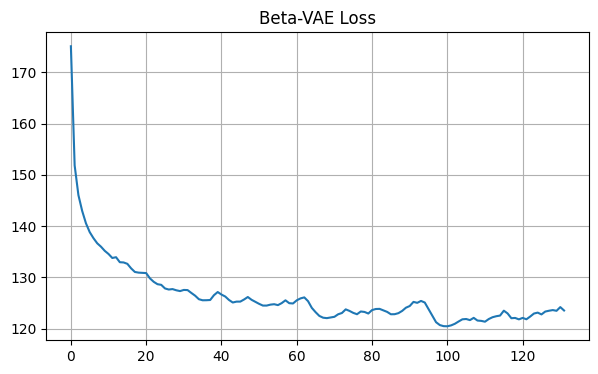

In [4]:
_ = model.train_vae(X_train, 1000, learning_rate=3e-3, batch_size=256, print_error_every=10, patience=30)

Test loss = 129.4611


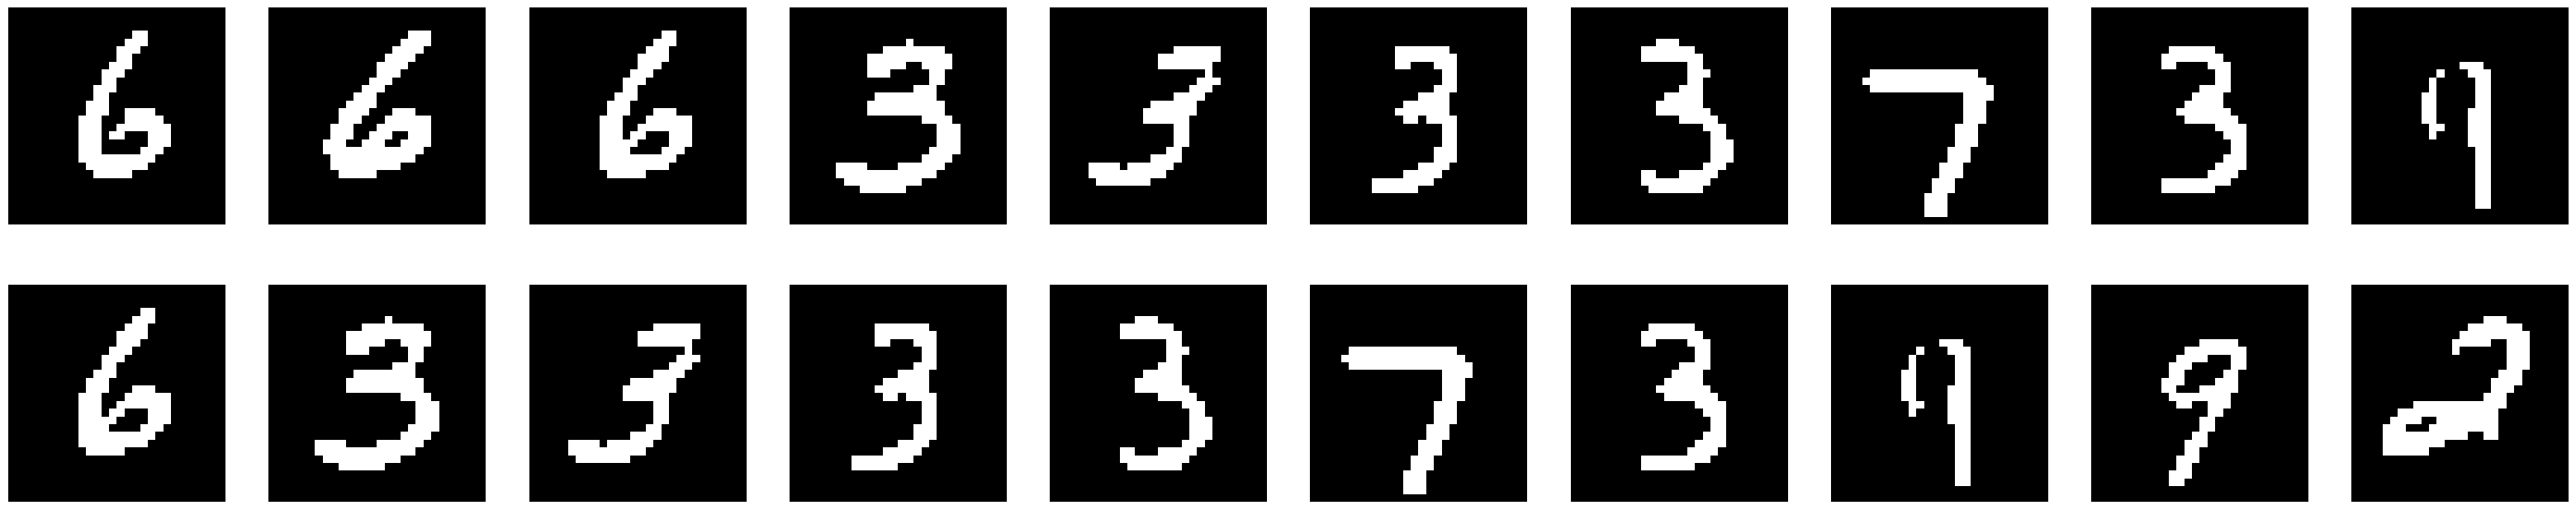

In [5]:
l, r = model.test_vae(X_test, ncols=10, nb_to_plot=20)

## Generate new samples

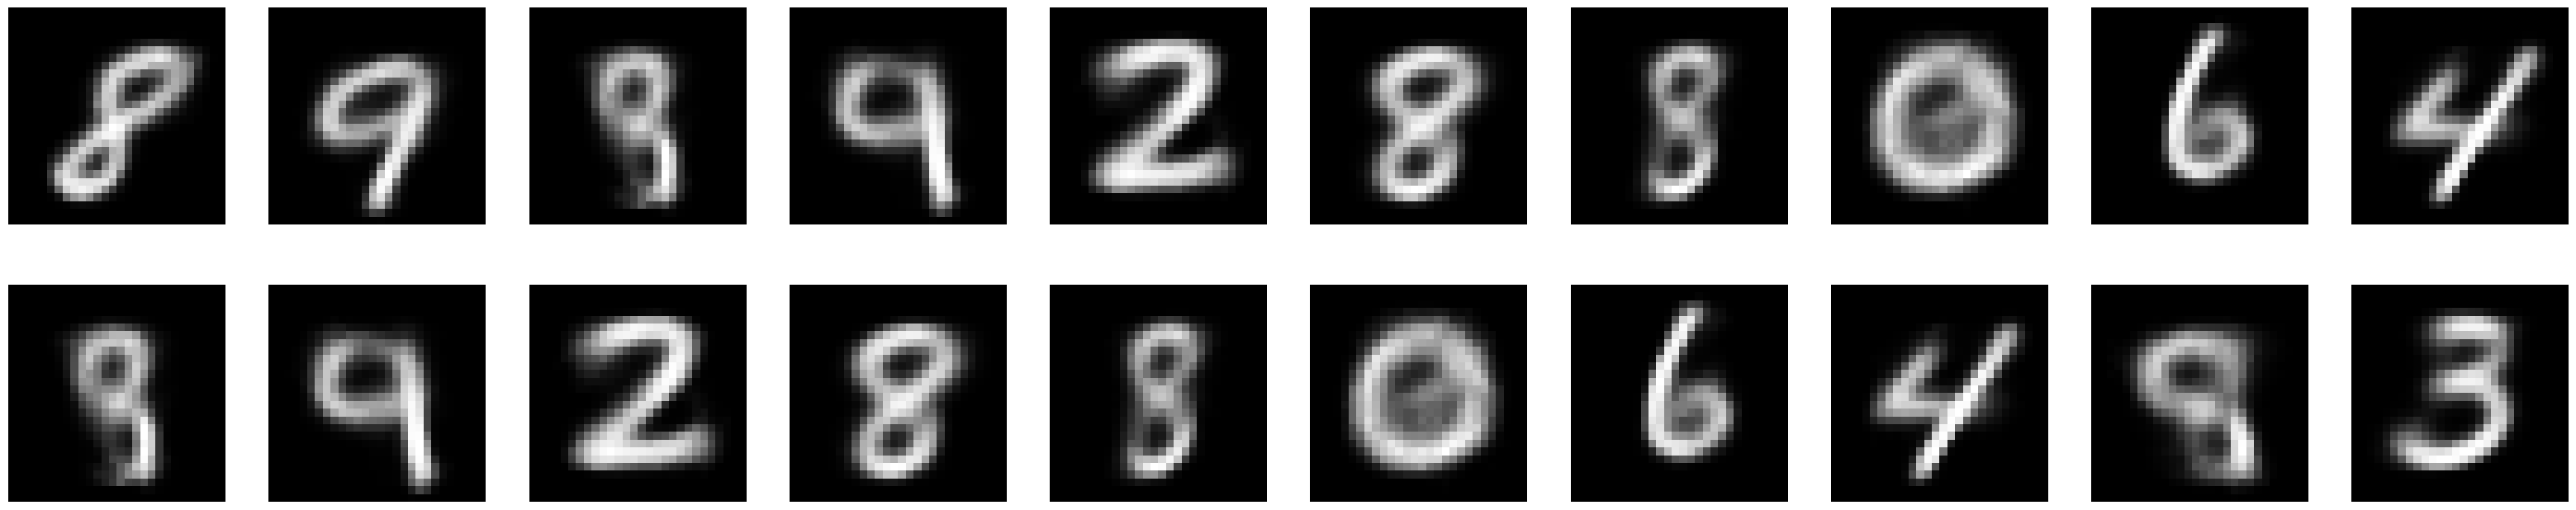

In [6]:
### plot images generated as gray scale ### 
gen = model.generate_data(binary=False)

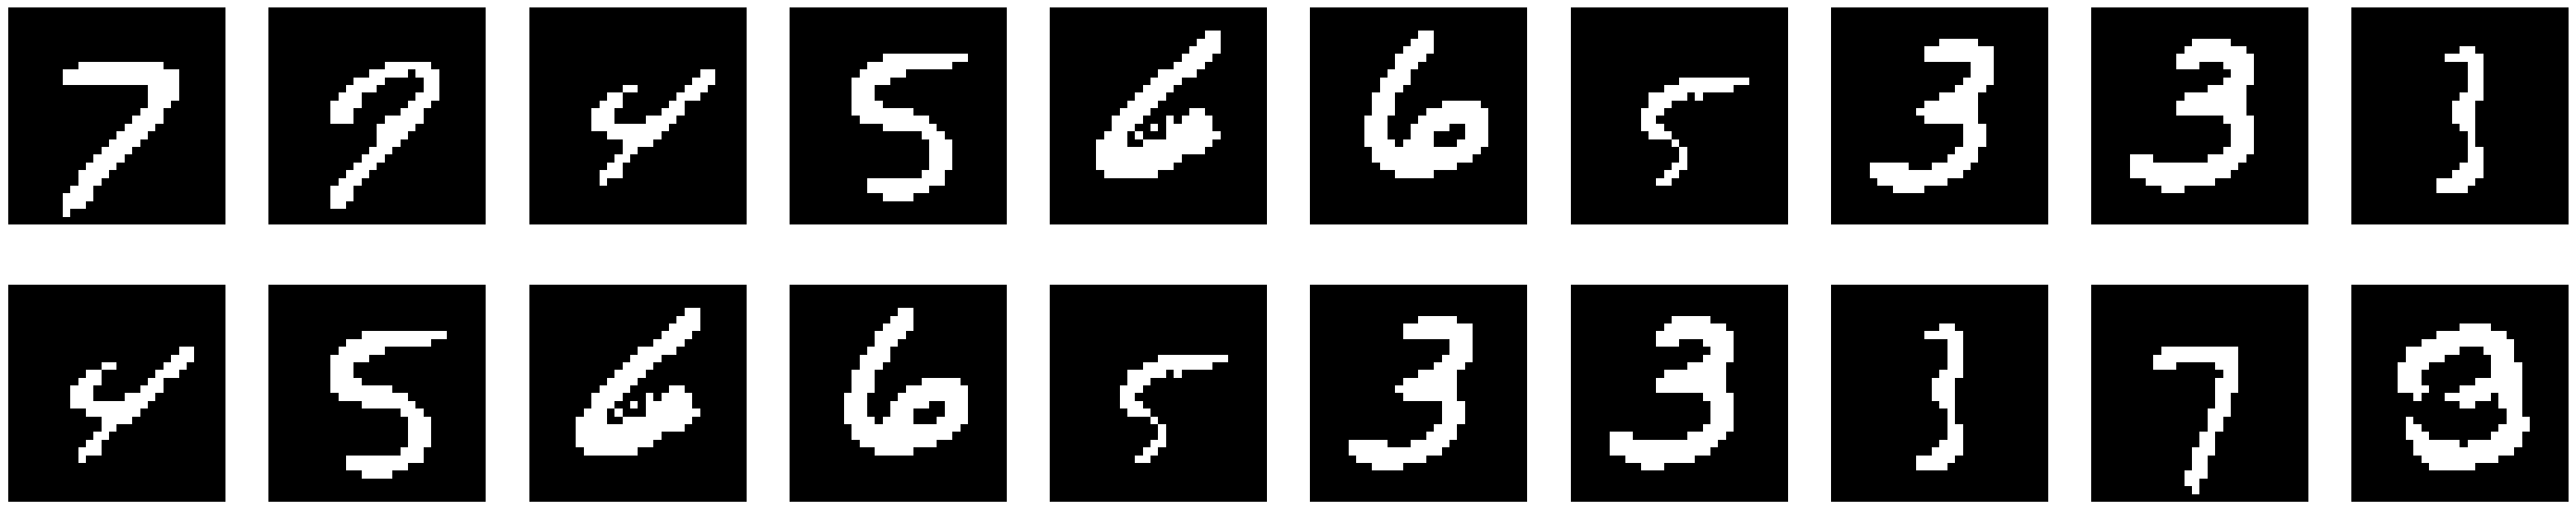

In [7]:
### plot images generated as binary images ### 
gen = model.generate_data()

### Sample latent space

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

In [9]:
grid = [[x, y] for x in norm.ppf(np.linspace(0.05, 0.995, 5)) for y in norm.ppf(np.linspace(0.05, 0.995, 5))]
latent_space_traversal = model.generate_samples(samples_pz=torch.tensor(grid, dtype=torch.float32).to(model.device))['generations'].detach().cpu().numpy()
latent_space_traversal = latent_space_traversal.squeeze()

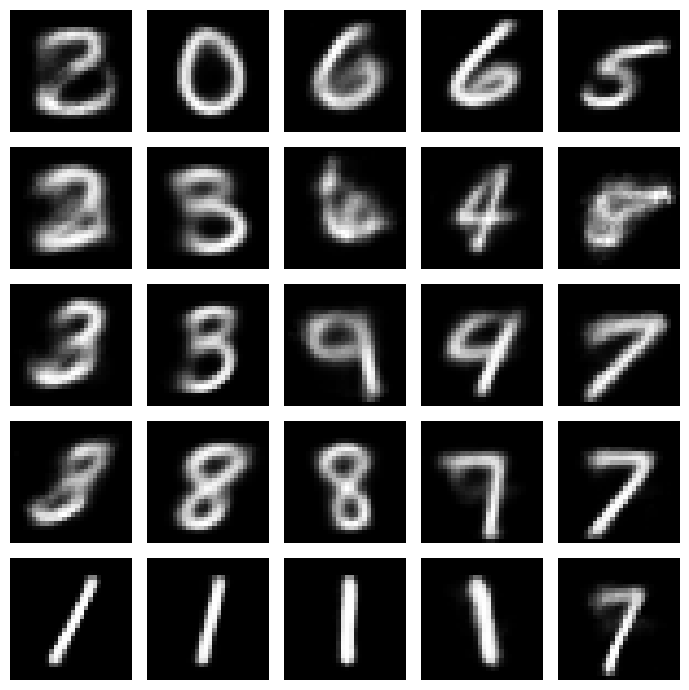

In [10]:
fig, axs = plt.subplots(5, 5, figsize=(7, 7))

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        ax.imshow(latent_space_traversal[5*i+j].reshape(28, 28), cmap='gray')
        ax.axis('off')
plt.tight_layout();

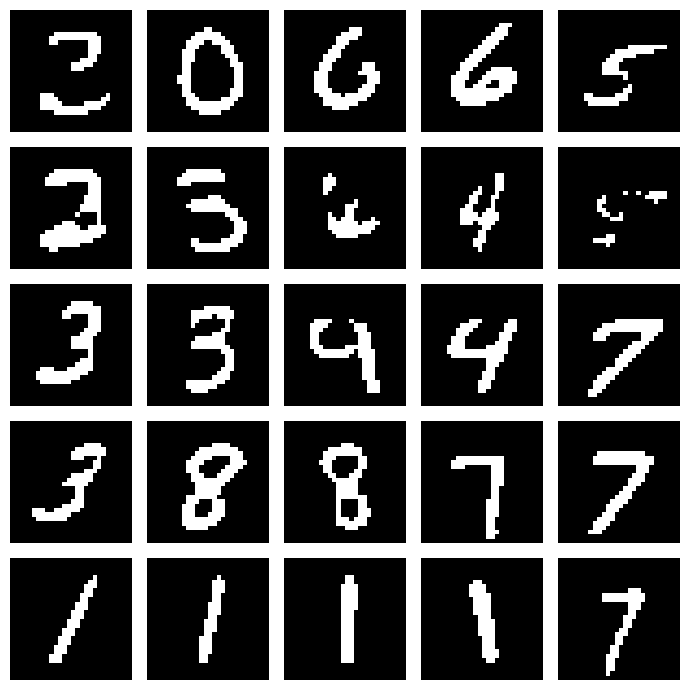

In [11]:
fig, axs = plt.subplots(5, 5, figsize=(7, 7))

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        z = np.where(latent_space_traversal[5*i+j].reshape(28, 28) >=0.5, 1, 0)
        ax.imshow(z, cmap='gray')
        ax.axis('off')
plt.tight_layout();

In [12]:
model.compute_fid_score(X_test[:5000])

927.6501081749627

## Tune hyperparameters to minimize FID

In [3]:
import pickle
from tqdm import tqdm
from IPython.display import clear_output

PATH = './vae_fid_scores.pkl'

def load_dict(path=PATH):
    with open(path, 'rb') as handle:
        d = pickle.load(handle)
    return d

def save_dict(d, path=PATH):
    with open(path, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
betas = [0.01, 0.1, 0.5, 1, 1.5, 2.5, 5, 10, 100]
latent_dims = [2, 3, 5, 10, 100, 200, 500]
alpha_lrelus = [0, 0.01, 0.1, 0.3, 0.5]

In [5]:
nb_to_test = len(betas) * len(latent_dims) * len(alpha_lrelus)

counter = 0
best_fid = np.inf
with tqdm(range(nb_to_test), unit='VAE') as bar:
    for alpha_lrelu in alpha_lrelus:
        for latent_dim in latent_dims:
            for beta in betas:
                bar.set_description(f'VAE {counter}: beta={beta}, latent_dim={latent_dim}, alpha={alpha_lrelu}')

                dict_results = load_dict(PATH)
                if dict_results.get(f'{beta},{latent_dim},{alpha_lrelu}') is not None:
                    fid_score = dict_results.get(f'{beta},{latent_dim},{alpha_lrelu}')
                else:
                    model = VAEModel(latent_dim=latent_dim, beta=beta, alpha_lrelu=alpha_lrelu)
                    _ = model.train_vae(X_train, 1000, learning_rate=3e-3, batch_size=256, print_error_every=-1, patience=30)
                    fid_score = model.compute_fid_score(X_test[:5000])
                    dict_results[f'{beta},{latent_dim},{alpha_lrelu}'] = fid_score
                    save_dict(dict_results, PATH)

                counter += 1
                if fid_score <= best_fid:
                    best_fid = fid_score
                    best_beta = beta
                    best_latent_dim = latent_dim
                    best_alpha_lrelu = alpha_lrelu

                bar.set_postfix(fid=best_fid, beta=best_beta, alpha=best_alpha_lrelu, l_dim=best_latent_dim, fid_cur=fid_score)
                bar.update(1)
                clear_output(wait=False)

VAE 122: beta=2.5, latent_dim=500, alpha=0.01:  39%|███▊      | 122/315 [8:54:10<23:39:36, 441.33s/VAE, alpha=0.01, beta=0.01, fid=915, fid_cur=921, l_dim=10]